In [1]:
# a notebook for verifying DQN implementation
# + investigate how (well) it learns

# remember to install the Axelrod library before running the following code
# also, have a look on network.ipynb first

In [2]:
%load_ext autoreload
%autoreload 2

import gc
import numpy as np
import axelrod as axl  # https://axelrod.readthedocs.io/en/stable/index.html
from time import time
from pprint import pprint
import matplotlib.pyplot as plt

np.set_printoptions(precision=3)

# the following imports are from network / axl_utils folder
import network
from axl_utils import NNplayer, State, set_match, set_play

In [3]:
C = axl.Action.C
D = axl.Action.D

# config game rules
# set_match & set_play function could be found inside axl_utils/game.py
GAME_LEN = 20 + 1
GAME = axl.Game(r=3, s=0, t=5, p=1)
Match = set_match(game=GAME, turns=GAME_LEN)
play = set_play(Match)

In [4]:
# the play function set up match between 2 players, print the result then return the match object
game = play(axl.Prober4(), axl.TitForTat())
game

[(3, 3), (3, 3), (5, 0), (0, 5), (5, 0), (1, 1), (1, 1), (0, 5), (3, 3), (5, 0), (0, 5), (5, 0), (0, 5), (3, 3), (5, 0), (0, 5), (5, 0), (1, 1), (0, 5), (5, 0)]
Player 1 score = 50
Player 2 score = 45


### Section 0: data

In [5]:
# an brief intro to the data

# State class could be found under axl_utils/nnplayer.py
# create a state container by
state = State(GAME_LEN, C=1, D=0.1, N=-1)
# the hyperparameters specify how we encode the environment
# '1' represent cooperation
# '0.1' represent defection
# '-1' means the turn has not happened yet

# this created a empty state that looks like this
current_state = state.values()
print("(1) current state")
print(current_state)


# assume we have a interaction between players, where we cooperated, and the opponent defected
# thus our action = C
# reward = 0 from the standard payoff matrix
action = C
reward = 0
# to record this interaction into the state:
state.push(C, D)

# updated state looks like this
next_state = state.values()
print("\n(2) next state")
print(next_state)
# New interactions are pushed to the *END* of the array
# this way the latest interaction is always fixed on the same positioin
# I hope this would help our algorithm to learn tit-for-tat


# Transition records what occured in the game, for our neural network to learn
# a Transition = (current_state, action, next_state, reward)
# so the above transition would be
from network.dqn import Transition
transition = Transition(current_state, action, next_state, reward)
print("\n(3) Transition")
print(transition)
# these form the data in this project


# a ReplayMemory is just a container to store the Transitions and feed to our neural network
memory = network.ReplayMemory(2)  # <- control the size
[memory.push(*transition) for i in '1234'];
print("\n(4) Memory")
print(memory)

# (check the code in axl_utils/nnplayer.py & network/dqn for details)

del memory, transition, Transition, current_state, action, next_state, reward

(1) current state
[[[-1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1]
  [-1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1]]]

(2) next state
[[[-1.  -1.  -1.  -1.  -1.  -1.  -1.  -1.  -1.  -1.  -1.  -1.  -1.  -1.
   -1.  -1.  -1.  -1.  -1.  -1.   1. ]
  [-1.  -1.  -1.  -1.  -1.  -1.  -1.  -1.  -1.  -1.  -1.  -1.  -1.  -1.
   -1.  -1.  -1.  -1.  -1.  -1.   0.1]]]

(3) Transition
Transition(state=array([[[-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
         -1, -1, -1, -1, -1],
        [-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
         -1, -1, -1, -1, -1]]]), action=C, next_state=array([[[-1. , -1. , -1. , -1. , -1. , -1. , -1. , -1. , -1. , -1. ,
         -1. , -1. , -1. , -1. , -1. , -1. , -1. , -1. , -1. , -1. ,
          1. ],
        [-1. , -1. , -1. , -1. , -1. , -1. , -1. , -1. , -1. , -1. ,
         -1. , -1. , -1. , -1. , -1. , -1. , -1. , -1. , -1. , -1. ,
          0.1]]]), reward=0)

(4) Memory
deque([Tra

### Section 1: DQN

In [6]:
# DQN class is inside network/dqn.py
# it defines how the network make decision + how it learns
# the implementation are not mentioned in this notebook
# please have a look at the .py file directly
# I've commented most of them

dqn = network.DQN([
                    network.Flatten_layer(),
                    network.Linear_layer(GAME_LEN*2, 100),
                    network.Activation_layer('ReLU'),
                    network.Linear_layer(100, 200),
                    network.Activation_layer('ReLU'),
                    network.Linear_layer(200, 100),
                    network.Activation_layer('ReLU'),
                    network.Linear_layer(100, 2),
                    ],
            network.ReplayMemory(2000), gamma=0.9, greedy=0.2)

# NNplayer class is inside axl_utils/nnplayer.py
# it integrates our DQN with the axl library
# to allow it play under axl's environment

p1 = NNplayer(dqn, State(GAME_LEN))
del dqn
gc.collect()

param = {"lr": 1e-4, 'batch': 64, "mode": "train", "eps": 1e-16, "epoch": 0, 't': 1, 'clip': 1.0,
         'optimizer': ('Adam', 0.9, 0.999), 'regularizer': None, "loss_fn":"mse"}

In [7]:
# 'with' statement makes my DQN enter test mode
# where its episilon-greedy is set to 0 (no random exploration)
# + printing our the estimated Q-value

with p1:
    players = (p1, axl.TitForTat())
    game = Match(players)
    game.play()
    
# initial Q_value predictions:

[[-0.209 -0.299]]
[[ 0.356 -0.105]]
[[ 0.604 -0.605]]
[[ 0.956 -0.371]]
[[ 1.47  -1.321]]
[[ 0.954 -0.429]]
[[ 0.592 -0.333]]
[[ 0.755 -0.752]]
[[ 1.271 -1.549]]
[[ 0.99  -1.541]]
[[ 1.099 -0.905]]
[[ 1.329 -0.569]]
[[ 1.587 -0.244]]
[[ 1.128 -1.079]]
[[ 0.783 -1.978]]
[[ 1.039 -2.579]]
[[ 1.109 -1.833]]
[[ 2.248 -1.75 ]]
[[ 2.191 -1.789]]
[[ 1.881 -2.187]]
[[ 1.112 -2.521]]


In [8]:
# collecting initial experience
# high greedy -> more random exploration

p1.network.greedy= 0.8
for i in range(60):
    players = (p1, axl.TitForTat())
    game = Match(players)
    game.play()
p1.network.greedy= 0.2

In [9]:
# theoritical Q values
# assuming the player cooperate til the last turn, then defect
# apply annuity formula with cashflow = 3.0, interest rate = 1/9, periods = 20 turns
# * the (1/9) come from our hyperparameter gamma, which is set to 0.9 by default
# then compensate the defection in 2nd last turn, and hard code the 21st turn to 0.0 (last turn must be 0 for DQN to learn)
true_Q = np.array([3.0/(1/9) * (1.0 - 1.0/(1.0+1/9)**(19-i)) + 5.0 if i<20 else 0.0 for i in range(21)])
[print(f'{i:.2f}') for i in true_Q];

28.35
27.95
27.50
27.00
26.44
25.82
25.14
24.37
23.53
22.59
21.54
20.38
19.09
17.65
16.06
14.29
12.32
10.13
7.70
5.00
0.00


In [10]:
# training loop

score_ls = []
errors = []
for _ in range(20):
    start = time()
    
    # calling train method bound to NNplayer/DQN class
    # detailed documentation are in .py files
    p1.train(30, param)
    
    # collect new experience with the trained network
    [Match((p1, axl.TitForTat())).play() for _ in range(10)]
    
    print(f'loss: {p1.network.loss},            time: +{time()-start:.2f} sec')
    
    # calculating Q-value error for later use
    # a bit tedious here but I'm too lazy to fix
    values = []
    state = State(21)
    for i in range(21):
        value = p1.network(state.values())[0]
        if i != 19:
            values.append(value[0])
        else:
            values.append(value[1])  # defection on 20th turn
        state.push(C, C) 
    error = true_Q - np.array(values)
    errors.append(error)


# left: running loss for cooperation
# right: running loss for defection

loss: [0.369 0.707],            time: +3.92 sec
loss: [0.19  0.194],            time: +4.49 sec
loss: [0.124 0.13 ],            time: +5.20 sec
loss: [0.084 0.094],            time: +7.18 sec
loss: [0.068 0.074],            time: +6.93 sec
loss: [0.061 0.056],            time: +7.15 sec
loss: [0.056 0.05 ],            time: +6.20 sec
loss: [0.04  0.035],            time: +7.04 sec
loss: [0.032 0.027],            time: +6.40 sec
loss: [0.038 0.032],            time: +6.40 sec
loss: [0.04  0.041],            time: +6.34 sec
loss: [0.029 0.033],            time: +7.40 sec
loss: [0.022 0.029],            time: +5.87 sec
loss: [0.023 0.03 ],            time: +5.77 sec
loss: [0.023 0.025],            time: +6.83 sec
loss: [0.023 0.027],            time: +6.29 sec
loss: [0.025 0.023],            time: +6.41 sec
loss: [0.026 0.03 ],            time: +7.92 sec
loss: [0.018 0.021],            time: +7.15 sec
loss: [0.015 0.019],            time: +6.68 sec


In [11]:
with p1:
    play(p1, axl.TitForTat())
# predicted Q-values after training:

# * 21st turn is dropped by my 'play' function
# because our DQN cannot learn it
# so the following results are for a 20 turn IPD

[[26.67  26.021]]
[[26.095 25.479]]
[[25.744 25.063]]
[[25.404 24.683]]
[[24.924 24.148]]
[[24.367 23.649]]
[[23.701 22.981]]
[[22.956 22.205]]
[[22.147 21.418]]
[[21.287 20.527]]
[[20.319 19.563]]
[[19.223 18.495]]
[[17.988 17.273]]
[[16.68  15.974]]
[[15.226 14.492]]
[[13.592 12.888]]
[[11.785 11.037]]
[[9.703 8.898]]
[[7.529 5.757]]
[[2.992 5.037]]
[[0.002 0.012]]
[(3, 3), (3, 3), (3, 3), (3, 3), (3, 3), (3, 3), (3, 3), (3, 3), (3, 3), (3, 3), (3, 3), (3, 3), (3, 3), (3, 3), (3, 3), (3, 3), (3, 3), (3, 3), (3, 3), (5, 0)]
Player 1 score = 62
Player 2 score = 57


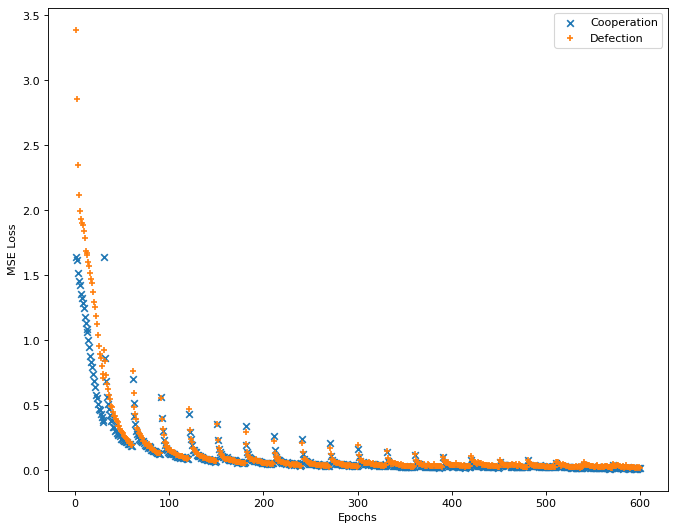

In [12]:
# training loss
# the beauty of double DQN
p1.plot()

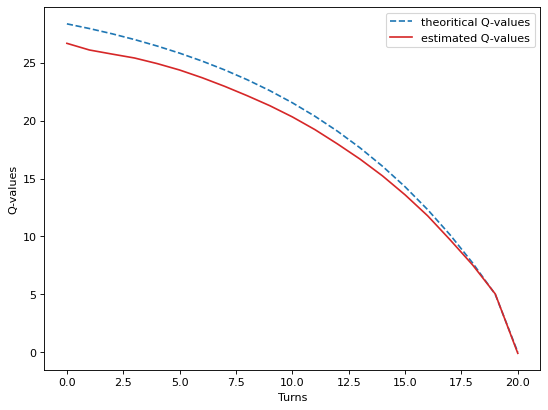

In [13]:
# visualize how fit our estimated Q-values is compared to theoretical values
plt.figure(figsize=(8, 6), dpi=80)
plt.plot(range(21), true_Q, '--', c='tab:blue', label='theoritical Q-values')
plt.plot(range(21), values, c='tab:red', label='estimated Q-values')
plt.xlabel('Turns')
plt.ylabel('Q-values')
plt.legend(loc='upper right')
plt.show()

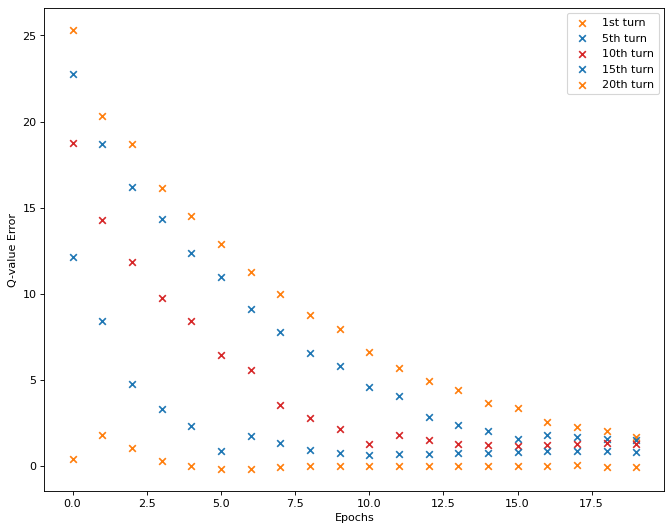

In [15]:
# visualizing the recursion nature of Bellman's equation,
# where the later states has to be learnt prior to learning preceding states

# plotting the error between our prediction against the theoritical Q-value
errors = np.array(errors)
plt.figure(figsize=(10, 8), dpi=80)
plt.scatter(range(len(errors)), errors[:,0], c='tab:orange', marker='x', label='1st turn')
plt.scatter(range(len(errors)), errors[:,4], c='tab:blue', marker='x', label='5th turn')
plt.scatter(range(len(errors)), errors[:,9], c='tab:red', marker='x', label='10th turn')
plt.scatter(range(len(errors)), errors[:,14], c='tab:blue', marker='x', label='15th turn')
plt.scatter(range(len(errors)), errors[:,19], c='tab:orange', marker='x', label='20th turn')
plt.legend(loc='upper right')
plt.xlabel('Epochs')
plt.ylabel('Q-value Error')
plt.show()

# due to the recursion
# V(current) is dependent on V(next)
# meaning that 1st turn will not be correctly learnt until the 2nd got the right value
# resulting in the gaps below

# this is similar to how tabular Q learning works via dynamic programming

### Section 2: DQN without fixed target (single DQN)

In [16]:
dqn2 = network.DQN([
                    network.Flatten_layer(),
                    network.Linear_layer(GAME_LEN*2, 100),
                    network.Activation_layer('ReLU'),
                    network.Linear_layer(100, 200),
                    network.Activation_layer('ReLU'),
                    network.Linear_layer(200, 100),
                    network.Activation_layer('ReLU'),
                    network.Linear_layer(100, 2),
                    ],
            network.ReplayMemory(2000), gamma=0.9, greedy=0.2)
p2 = NNplayer(dqn2, State(GAME_LEN))
del dqn2
gc.collect()

param = {"lr": 1e-4, 'batch': 64, "mode": "train", "eps": 1e-16, "epoch": 0, 't': 1, 'clip': 1.0,
         'optimizer': ('Adam', 0.9, 0.999), 'regularizer': None, "loss_fn":"mse"}

p2.set_greedy(0.8)
for i in range(60):
    players = (p2, axl.TitForTat())
    game = Match(players)
    game.play()
p2.set_greedy(0.2)

for _ in range(100):
    start = time()
    
    p2.train(1, param)  # my train function updates target net at the end via deepcopy, we can overwrite this by
    p2.network.target_net = p2.network.policy_net  # shallow copy policy net to target net
    
    [Match((p2, axl.TitForTat())).play() for _ in range(10)]
    print(f'loss: {p2.network.loss},            time: +{time()-start:.2f} sec')

loss: [1.493 3.313],            time: +0.45 sec
loss: [1.94  3.703],            time: +0.51 sec
loss: [2.027 3.496],            time: +0.55 sec
loss: [2.076 3.163],            time: +0.56 sec
loss: [2.16  2.796],            time: +0.51 sec
loss: [2.158 2.613],            time: +0.50 sec
loss: [2.119 2.535],            time: +0.60 sec
loss: [2.19  2.618],            time: +0.55 sec
loss: [2.408 2.814],            time: +0.56 sec
loss: [2.292 2.905],            time: +0.67 sec
loss: [2.423 2.99 ],            time: +0.58 sec
loss: [2.479 3.08 ],            time: +0.56 sec
loss: [2.666 3.18 ],            time: +0.49 sec
loss: [2.943 3.455],            time: +0.48 sec
loss: [3.393 3.779],            time: +0.52 sec
loss: [3.828 4.338],            time: +0.56 sec
loss: [4.57  4.911],            time: +0.62 sec
loss: [5.437 5.282],            time: +0.63 sec
loss: [6.191 6.096],            time: +0.52 sec
loss: [7.247 6.974],            time: +0.54 sec
loss: [8.185 7.638],            time: +0

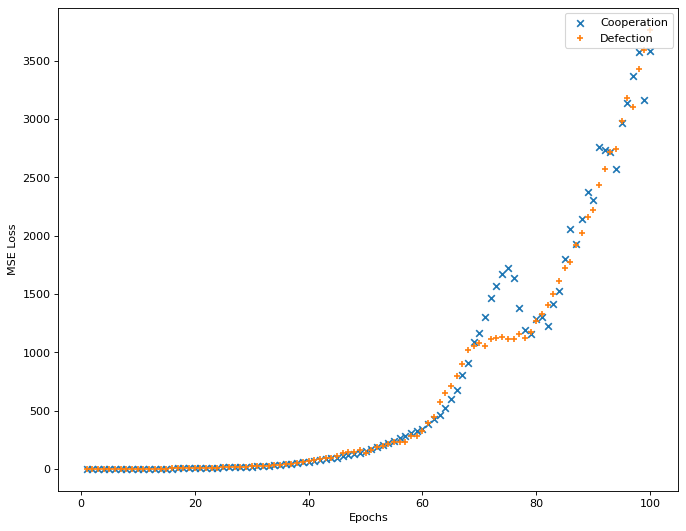

In [17]:
# see how loss grows exponentially without fixed target
p2.plot()

In [18]:
# result:
with p2:
    play(p2, axl.TitForTat())
    
# incorrect Q-values -> bad/random policy
# (run this section serveral time to see how the policy is effectively random)

[[1484.81  1756.586]]
[[3787.568 4196.109]]
[[-2805.456 -2747.947]]
[[4496.396 4946.291]]
[[-1128.209  -940.792]]
[[2593.19  2958.945]]
[[-1241.739 -1059.703]]
[[4550.811 5033.437]]
[[-2649.448 -2529.644]]
[[2577.042 2951.366]]
[[1319.323 1623.369]]
[[ 882.255 1162.805]]
[[-505.132 -306.398]]
[[3308.446 3684.287]]
[[-731.209 -547.447]]
[[-980.153 -836.561]]
[[2614.487 2904.018]]
[[-962.169 -860.475]]
[[ 62.687 176.906]]
[[ 908.529 1028.151]]
[[1192.086 1307.542]]
[(5, 0), (1, 1), (1, 1), (1, 1), (1, 1), (1, 1), (1, 1), (1, 1), (1, 1), (1, 1), (1, 1), (1, 1), (1, 1), (1, 1), (1, 1), (1, 1), (1, 1), (1, 1), (1, 1), (1, 1)]
Player 1 score = 24
Player 2 score = 19


In [19]:
del p2

### Section 3: testing the off-policyness

In [20]:
from axl_utils.extract import extract

In [21]:
# collecting experience from axl.Random
memory = network.ReplayMemory(10000)
for _ in range(500):
    game = play(axl.Random(), axl.TitForTat(), show=False)
    extract(game, memory)
    
print(len(memory))
# we can then pass this memory into a fresh DQN

10000


In [22]:
dqn3 = network.DQN([
                    network.Flatten_layer(),
                    network.Linear_layer(GAME_LEN*2, 100, bias=0.01),
                    network.Activation_layer('ReLU'),
                    network.Linear_layer(100, 200),
                    network.Activation_layer('ReLU'),
                    network.Linear_layer(200, 100),
                    network.Activation_layer('ReLU'),
                    network.Linear_layer(100, 2),
                    ],
            memory, gamma=0.9, greedy=0.2)  # <- feeding the memory from above
p3 = NNplayer(dqn3, State(GAME_LEN))
del dqn3
gc.collect()

param = {"lr": 1e-4, 'batch': 64, "mode": "train", "eps": 1e-16, "epoch": 0, 't': 1, 'clip': 1.0,
         'optimizer': ('Adam', 0.9, 0.999), 'regularizer': None, "loss_fn":"mse"}

In [23]:
for _ in range(20):
    start = time()
    p3.train(5, param)
    print(f'loss: {p3.network.loss},            time: +{time()-start:.2f} sec')

loss: [0.266 0.378],            time: +4.97 sec
loss: [0.253 0.278],            time: +5.21 sec
loss: [0.201 0.208],            time: +6.21 sec
loss: [0.179 0.189],            time: +4.98 sec
loss: [0.144 0.151],            time: +5.29 sec
loss: [0.127 0.146],            time: +4.49 sec
loss: [0.12 0.13],            time: +5.51 sec
loss: [0.114 0.122],            time: +5.13 sec
loss: [0.104 0.109],            time: +5.42 sec
loss: [0.1   0.111],            time: +5.12 sec
loss: [0.093 0.1  ],            time: +5.37 sec
loss: [0.086 0.09 ],            time: +4.71 sec
loss: [0.078 0.086],            time: +4.80 sec
loss: [0.075 0.078],            time: +5.38 sec
loss: [0.071 0.079],            time: +5.35 sec
loss: [0.068 0.077],            time: +5.43 sec
loss: [0.066 0.071],            time: +5.54 sec
loss: [0.062 0.065],            time: +5.47 sec
loss: [0.06  0.071],            time: +5.36 sec
loss: [0.058 0.068],            time: +5.26 sec


In [24]:
with p3:
    play(p3, axl.TitForTat())
    
# learns well, without ever playing the game

[[26.902 26.153]]
[[26.318 25.535]]
[[25.707 25.074]]
[[25.177 24.446]]
[[24.624 23.855]]
[[23.998 23.272]]
[[23.377 22.702]]
[[22.667 21.868]]
[[21.909 21.147]]
[[20.937 20.228]]
[[20.124 19.563]]
[[18.927 18.438]]
[[17.922 17.274]]
[[16.671 15.945]]
[[15.05  14.345]]
[[13.622 12.809]]
[[11.646 10.991]]
[[9.576 8.977]]
[[7.639 6.172]]
[[3.11  5.389]]
[[0.131 0.042]]
[(3, 3), (3, 3), (3, 3), (3, 3), (3, 3), (3, 3), (3, 3), (3, 3), (3, 3), (3, 3), (3, 3), (3, 3), (3, 3), (3, 3), (3, 3), (3, 3), (3, 3), (3, 3), (3, 3), (5, 0)]
Player 1 score = 62
Player 2 score = 57


In [25]:
del p3

### Section 4: but what did it learn?

In [26]:
# might be an obvious question but let's see what happens if our DQN meets provocative defection

p1.network.greedy = 0.0
play(p1, axl.HardProber());  # hard prober defects forever if its opponent does not retaliate

[(0, 5), (0, 5), (3, 3), (3, 3), (0, 5), (0, 5), (0, 5), (0, 5), (0, 5), (0, 5), (0, 5), (0, 5), (0, 5), (0, 5), (0, 5), (0, 5), (0, 5), (0, 5), (0, 5), (1, 1)]
Player 1 score = 7
Player 2 score = 92


In [27]:
play(axl.Cooperator(), axl.HardProber());  # => our DQN is basically a naive cooperator

[(0, 5), (0, 5), (3, 3), (3, 3), (0, 5), (0, 5), (0, 5), (0, 5), (0, 5), (0, 5), (0, 5), (0, 5), (0, 5), (0, 5), (0, 5), (0, 5), (0, 5), (0, 5), (0, 5), (0, 5)]
Player 1 score = 6
Player 2 score = 96


In [28]:
play(axl.TitForTat(), axl.HardProber());  # while TFT can generalize well to any opponent

[(0, 5), (1, 1), (5, 0), (3, 3), (3, 3), (3, 3), (3, 3), (3, 3), (3, 3), (3, 3), (3, 3), (3, 3), (3, 3), (3, 3), (3, 3), (3, 3), (3, 3), (3, 3), (3, 3), (3, 3)]
Player 1 score = 57
Player 2 score = 57


In [29]:
# => continue exploration on Stage 2

### Section 5: learning TFT with 2 perceptrons

In [30]:
# possible states of last turn
# where [1,1] means mutual cooperation
last_turn = np.array([[1,1],[0,1],[1,0],[0,0]])

# target
# => copy opponent's action
action = np.array([[1],[1],[0],[0]])

nn = network.NeuralNetwork([network.Linear_layer(2, 1)])
param = {"lr": 3e-2, 'batch': 2, "mode": "train", "eps": 1e-16, "epoch": 0, 't': 1, 'clip': 1.0,
         'optimizer': ('Adam', 0.9, 0.999), 'regularizer': None, "loss_fn":"mse"}

In [31]:
for i in range(40):
    nn.train(last_turn, action, param)
    action_ = np.round(nn(last_turn))
    accuracy = np.sum(action_==action) / len(action)
    print(f"Epoch {i}, Accuracy = {accuracy}")

Average loss = 0.324177, elapsed time = 0.00.
Epoch 0, Accuracy = 0.75
Average loss = 0.230611, elapsed time = 0.00.
Epoch 1, Accuracy = 0.75
Average loss = 0.137042, elapsed time = 0.00.
Epoch 2, Accuracy = 0.75
Average loss = 0.077147, elapsed time = 0.00.
Epoch 3, Accuracy = 1.0
Average loss = 0.051214, elapsed time = 0.00.
Epoch 4, Accuracy = 1.0
Average loss = 0.025074, elapsed time = 0.00.
Epoch 5, Accuracy = 1.0
Average loss = 0.024392, elapsed time = 0.00.
Epoch 6, Accuracy = 1.0
Average loss = 0.028575, elapsed time = 0.00.
Epoch 7, Accuracy = 1.0
Average loss = 0.034685, elapsed time = 0.00.
Epoch 8, Accuracy = 1.0
Average loss = 0.039249, elapsed time = 0.00.
Epoch 9, Accuracy = 1.0
Average loss = 0.039893, elapsed time = 0.00.
Epoch 10, Accuracy = 1.0
Average loss = 0.034930, elapsed time = 0.00.
Epoch 11, Accuracy = 1.0
Average loss = 0.028569, elapsed time = 0.00.
Epoch 12, Accuracy = 1.0
Average loss = 0.022309, elapsed time = 0.00.
Epoch 13, Accuracy = 1.0
Average loss 

In [32]:
# but obviously this is human-learning instead of machine learning
# will the DQN figure this out by itself?

# also, the architecture is more of a policy-gradient approach
# the regression nature of DQNs make it impossible to employ simple architecture